### Testing Network X Plot

Seeing if my kernel will crash if I try to plot a network graph with 1,000,000 millions plots.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import Modules
import datetime
import itertools
import graphviz 
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import scipy
import sklearn
import tensorflow as tf
import warnings
import xgboost

# Other Imports
from matplotlib import rcParams, gridspec
from scipy import io
from xgboost import XGBClassifier

# Keras Imports
from keras import models, layers
from keras import regularizers
import keras.backend as K
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier

# Scipy Imports
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

# Preprocesing
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler

# Sklearn Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report,
                             f1_score, precision_score, recall_score,
                             precision_recall_fscore_support, roc_auc_score)

# Model Selection
from sklearn.model_selection import (cross_val_score, KFold, train_test_split,
                                     GridSearchCV, cross_validate,
                                     StratifiedKFold)


# Set Numpy and Python Random Seed
seed = 7
np.random.seed(seed)

# Pandas Configuration
pd.set_option('max_columns', 1000)
pd.set_option('max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Warning Configuration
warnings.filterwarnings('ignore')

# Plotting Configuration
rcParams['figure.figsize'] = (12.0, 4.0)
rcParams.update({'font.size': 10})
colors = ['#74a9cf', '#6a51a3']

# Print versions of each package above 
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Sklearn version: {}".format(sklearn.__version__))
print("Keras version: {}".format(keras.__version__))
print("Scipy version: {}".format(scipy.__version__))
print("XBG Boost version: {}".format(xgboost.__version__))

Using TensorFlow backend.


Numpy version: 1.14.5
Pandas version: 0.23.4
Sklearn version: 0.19.0
Keras version: 2.2.2
Scipy version: 0.19.1
XBG Boost version: 0.72


In [4]:
def read_csv(path: str, lower=True) -> pd.DataFrame:
    '''Read in csv data return dataframe after lowering all columns name
    
    Parameters
    ----------
    path: Absolulte or Relative Path to csv data
    
    '''
    df = pd.read_csv('Data/Synthetic/synthetic.csv')
    if lower == True:
        df.columns = df.columns.str.lower()
    return df


# Import paysim data
sdf = read_csv('Data/Synthetic/synthetic.csv')
sdf = sdf.rename(columns={'isfraud':'target', 'oldbalanceorg':'oldbalanceorig'})
sdf.head(3)

step      type   amount     nameorig  oldbalanceorig  newbalanceorig  \
0     1   PAYMENT 9839.640  C1231006815      170136.000      160296.360   
1     1   PAYMENT 1864.280  C1666544295       21249.000       19384.720   
2     1  TRANSFER  181.000  C1305486145         181.000           0.000   

      namedest  oldbalancedest  newbalancedest  target  isflaggedfraud  
0  M1979787155           0.000           0.000       0               0  
1  M2044282225           0.000           0.000       0               0  
2   C553264065           0.000           0.000       1               0

In [ ]:
for i,j,k,l in list(sdf.head.itertuples(index=False, name=None)):
    print(i,j,k,l)

### Kv Way

In [8]:
import networkx as nx

In [60]:
sdf[sdf.target == 1].shape

(8213, 11)

In [72]:
sdf[sdf.target == 1].head(10)

step      type      amount     nameorig  oldbalanceorig  newbalanceorig  \
2        1  TRANSFER     181.000  C1305486145         181.000           0.000   
3        1  CASH_OUT     181.000   C840083671         181.000           0.000   
251      1  TRANSFER    2806.000  C1420196421        2806.000           0.000   
252      1  CASH_OUT    2806.000  C2101527076        2806.000           0.000   
680      1  TRANSFER   20128.000   C137533655       20128.000           0.000   
681      1  CASH_OUT   20128.000  C1118430673       20128.000           0.000   
724      1  CASH_OUT  416001.330   C749981943           0.000           0.000   
969      1  TRANSFER 1277212.770  C1334405552     1277212.770           0.000   
970      1  CASH_OUT 1277212.770   C467632528     1277212.770           0.000   
1115     1  TRANSFER   35063.630  C1364127192       35063.630           0.000   

         namedest  oldbalancedest  newbalancedest  target  isflaggedfraud  
2      C553264065           0.000           0.000       1               0  
3       C38997010       21182.000           0.000       1               0  
251    C972765878           0.000           0.000       1               0  
252   C1007251739       26202.000           0.000       1               0  
680   C1848415041           0.000           0.000       1               0  
681    C339924917        6268.000       12145.850       1               0  
724    C667346055         102.000     9291619.620       1               0  
969    C431687661           0.000           0.000       1               0  
970    C716083600           0.000     2444985.190       1               0  
1115  C1136419747           0.000           0.000       1               0

In [ ]:
data = sdf
data = data[['nameorig','namedest','target','amount']]
G = nx.DiGraph()
for i,j,k,l in list(data.itertuples(index=False, name=None)):
    G.add_edge(i,j, target=k, amount=l )

plt.figure(figsize=(30,30))
pos=nx.spring_layout(G) 
nx.draw_networkx_edges(G,pos);
nx.draw_networkx_nodes(G,pos, alpha=0.5);

In [75]:
data = sdf[sdf.target == 1].sample(8000)
data = data[['nameorig','namedest','target','amount']]
G = nx.DiGraph()
for i,j,k,l in list(data.itertuples(index=False, name=None)):
    G.add_edge(i,j, target=k, amount=l )

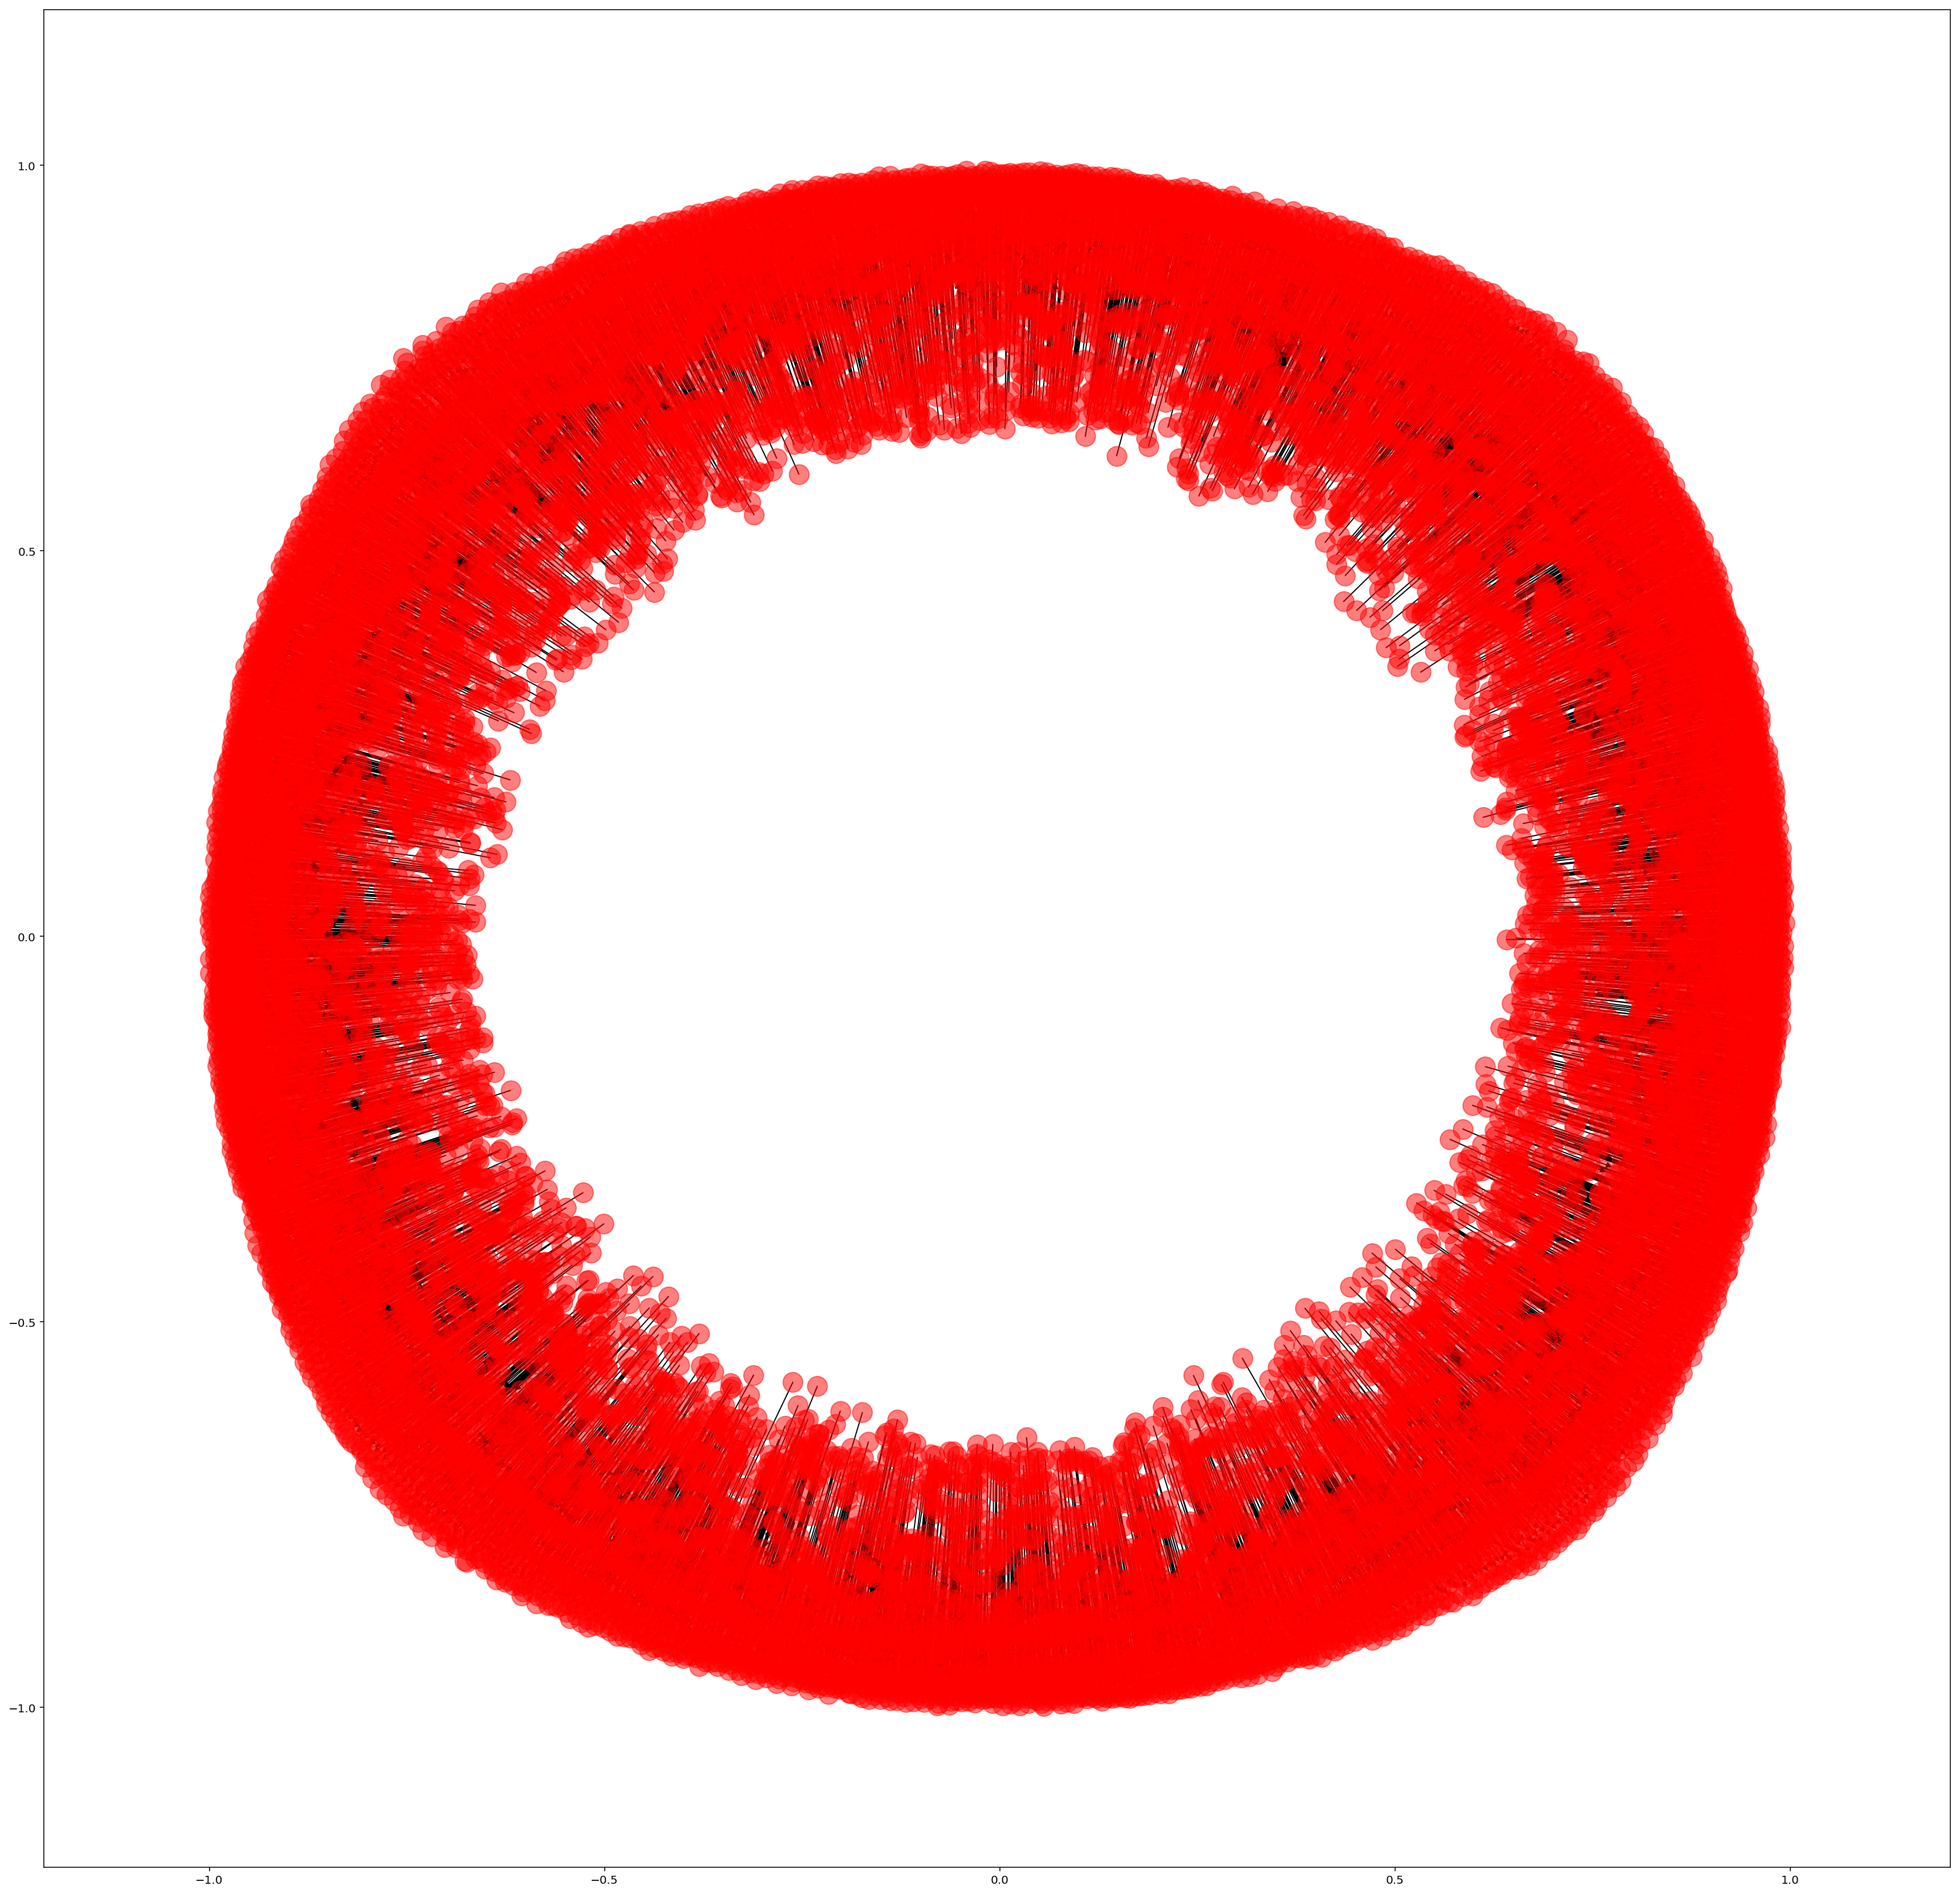

In [77]:
plt.figure(figsize=(30,30))
pos=nx.spring_layout(G) 
nx.draw_networkx_edges(G,pos);
nx.draw_networkx_nodes(G,pos, alpha=0.5);

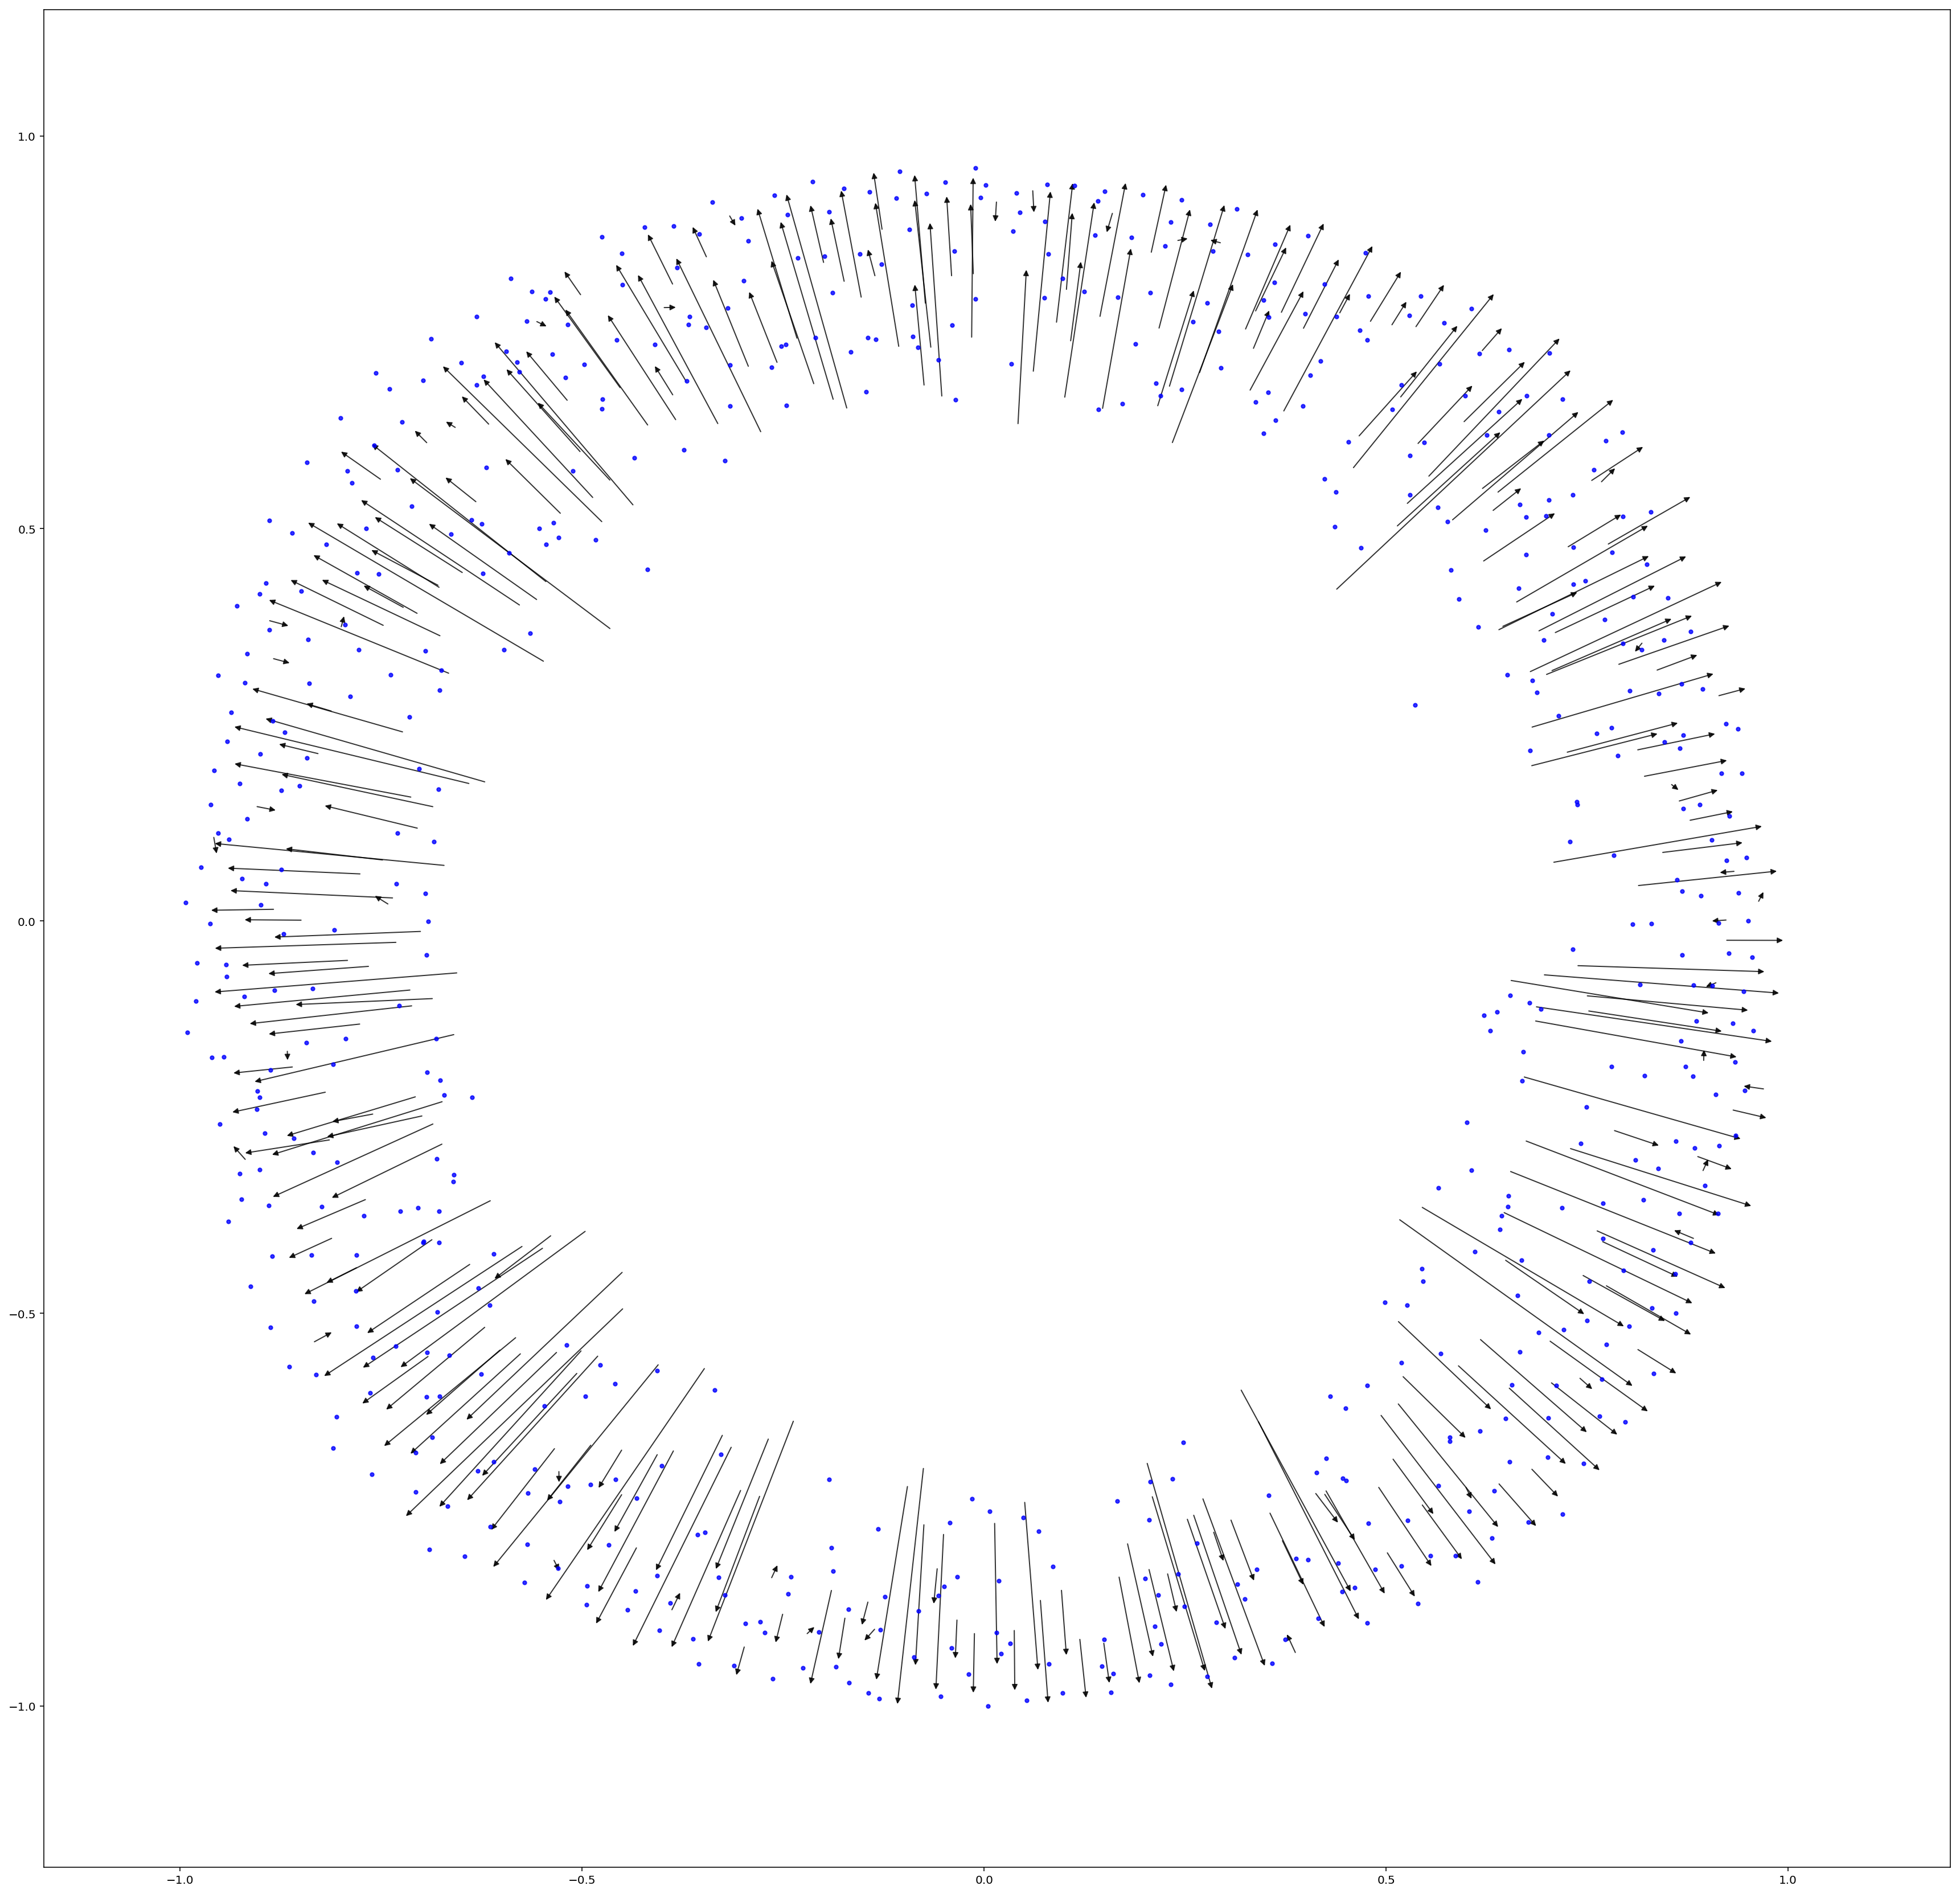

In [70]:
plt.figure(figsize=(30,30))
pos=nx.spring_layout(G) 
nx.draw_networkx_edges(G,pos,
                       node_color='b',
                       node_size=10,
                       alpha=0.8,
                       edge_cmap=plt.cm.Purples);
pos=nx.spring_layout(G) # Positions for all the nodes
nx.draw_networkx_nodes(G,pos,
                       node_color='b',
                       node_size=10,
                       alpha=0.8)

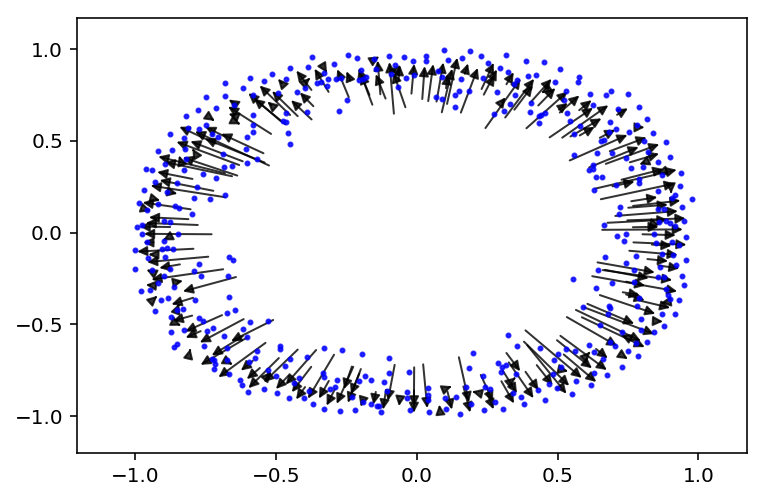

In [52]:
pos=nx.spring_layout(G) 
nx.draw_networkx_edges(G,pos,
                       node_color='b',
                       node_size=4,
                       alpha=0.8);
pos=nx.spring_layout(G) # Positions for all the nodes
nx.draw_networkx_nodes(G,pos,
                       node_color='b',
                       node_size=4,
                       alpha=0.8)

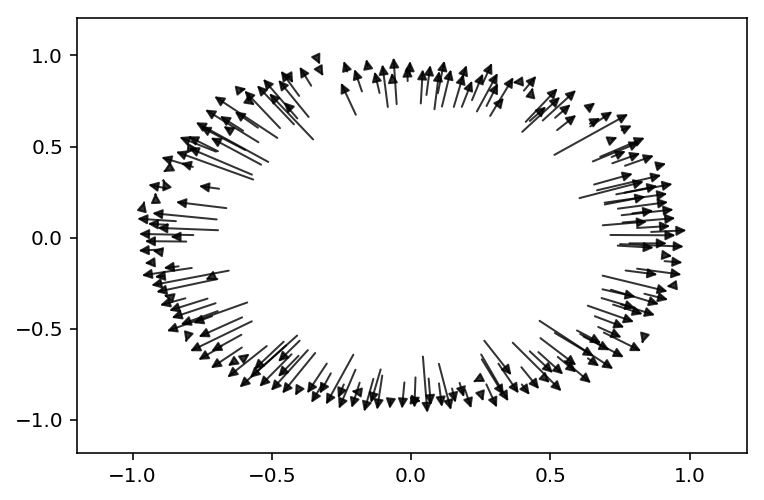

In [53]:
pos=nx.spring_layout(G) 
nx.draw_networkx_edges(G,pos,
                       node_color='b',
                       node_size=4,
                       alpha=0.8);

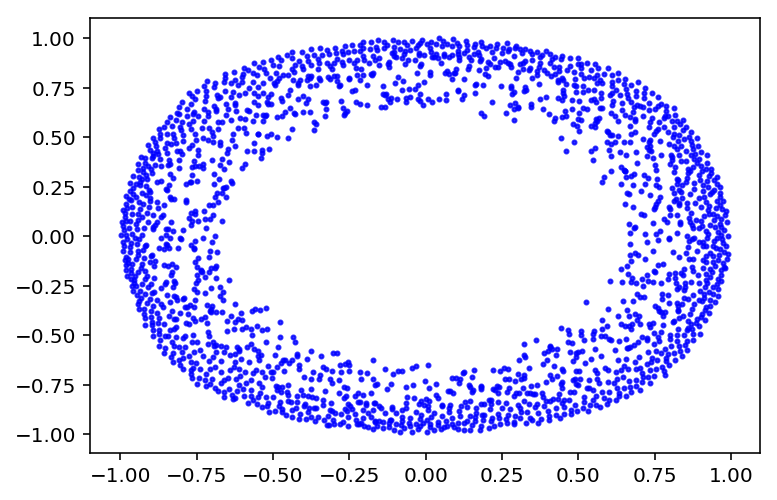

In [46]:
pos=nx.spring_layout(G) # Positions for all the nodes
nx.draw_networkx_nodes(G,pos,
                       node_color='b',
                       node_size=4,
                       alpha=0.8)


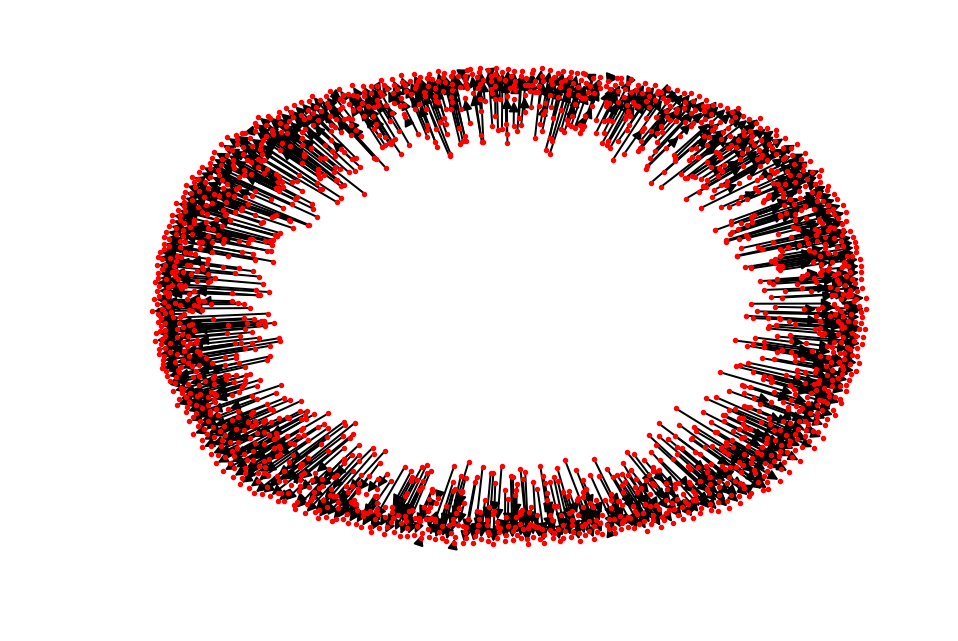

In [41]:
nx.draw(G, with_labels=False, font_weight='bold', node_size=3,
       color='green')

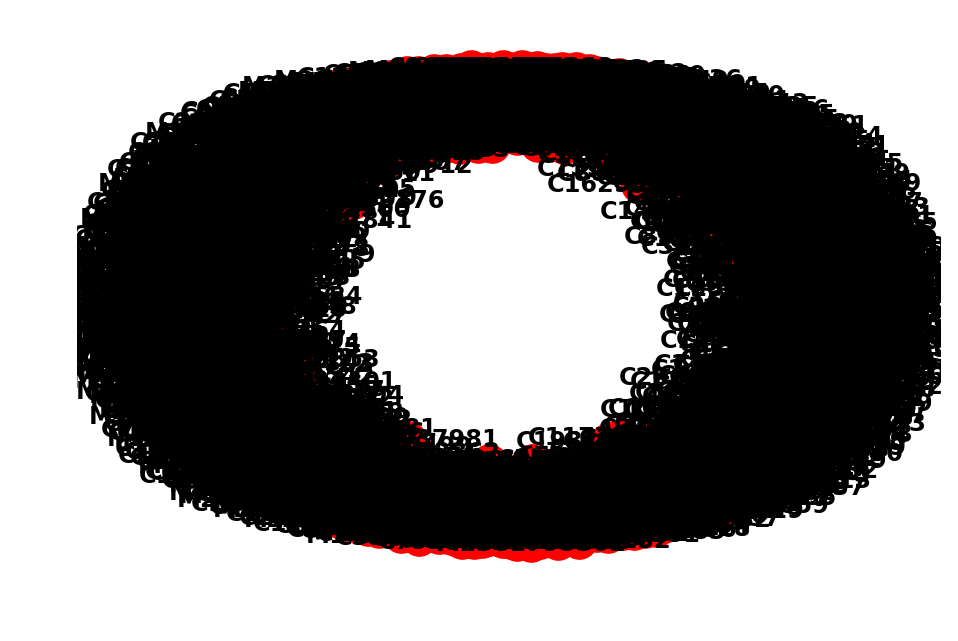

In [36]:
#nx.draw(G, with_labels=True, font_weight='bold')

In [30]:
G['C1231006815']

AtlasView({'M1979787155': {'target': 0, 'amount': 9839.64}})

### Js Ways

In [10]:
import pandas as pd
from itertools import combinations

In [11]:
### collapse to a series of lists
data = sdf.groupby('nameorig').apply(lambda x: list(x['target']))
print(data.shape )
### we can ignore 1 length baskets - no connections
data = data[data.apply(lambda x:len(x) > 1)]
print(data.shape )

#holding dict
mydict = {}

for i in range(len(data)):
    #2 combinations of baskets
    for j,k in combinations(data[i],2):
        #setdefauly, and append a 1 for each time it is found
        mydict.setdefault((j,k),[]).append(1)

#make a graph
G = nx.Graph()

#_ = [G.add_edge(i[0], i[1], weight = len(j)) for i,j in mydict.items() if len(j) > 20];

(6353307,)
(9298,)


In [ ]:
data

In [12]:
data.head()

nameorig
C100025963     [0, 0]
C1000442951    [0, 0]
C1000947901    [0, 0]
C1001064466    [0, 0]
C1001477354    [0, 0]
dtype: object

In [13]:
mydict

{(0, 0): [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  